In [1]:
!lsb_release -a
!pwd
!python -V
!which python
# --- EXPECT:
# No LSB modules are available.
# Distributor ID:	Ubuntu
# Description:	Ubuntu 18.04.1 LTS
# Release:	18.04
# Codename:	bionic
# /data/learn/fucap/data_cleanup
# Python 2.7.15 :: Anaconda, Inc.
# /home/neuronq/miniconda3/envs/fucap/bin/python

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.1 LTS
Release:	18.04
Codename:	bionic
/data/learn/fucap/data_cleanup
Python 2.7.15 :: Anaconda, Inc.
/home/neuronq/miniconda3/envs/fucap/bin/python


In [27]:
# autoreload
%load_ext autoreload
%autoreload 1

# write code that works in both Python 2 (2.7+) and 3 (3.5+)
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    input = raw_input
    range = xrange
except NameError:
    pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import os
import sys
from datetime import datetime
import datetime as dtm
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pprint
pp = pprint.PrettyPrinter(indent=2).pprint
from IPython.display import display as dd
from IPython.display import Image

%matplotlib inline

In [28]:
# add project dir to import path
project_dir = os.path.split(os.getcwd())[0]
if project_dir not in sys.path:
    sys.path.append(project_dir)

%aimport lib.visualization
%aimport lib.helpers
from lib.visualization import simple_plot
import lib.helpers as helpers

In [26]:
INPUT_FILENAME = '../data_src/btc.300s.cbpro.csv'
OUT_FILENAME = '../data_clean/btc.300s.cbpro.csv'

size: 388209


,datetime,low,high,open,close,volume
timestamp,,,,,,
1417416600,2014-12-01 06:50:00,370.00,370.0,370.00,370.0,0.026556
1417497900,2014-12-02 05:25:00,377.00,377.0,377.00,377.0,0.010000
1417517700,2014-12-02 10:55:00,377.75,378.0,377.75,378.0,4.000000
1417518000,2014-12-02 11:00:00,378.00,378.0,378.00,378.0,4.900000
1417518300,2014-12-02 11:05:00,378.00,378.0,378.00,378.0,5.200000


,datetime,low,high,open,close,volume
timestamp,,,,,,
1539128100,2018-10-09 23:35:00,6590.30,6593.48,6591.54,6590.30,17.148190
1539128400,2018-10-09 23:40:00,6586.55,6590.31,6590.31,6589.30,15.269094
1539128700,2018-10-09 23:45:00,6589.29,6589.69,6589.30,6589.48,12.466310
1539129000,2018-10-09 23:50:00,6589.47,6592.81,6589.48,6591.85,14.972801
1539129300,2018-10-09 23:55:00,6589.47,6592.81,6591.84,6589.48,31.305392


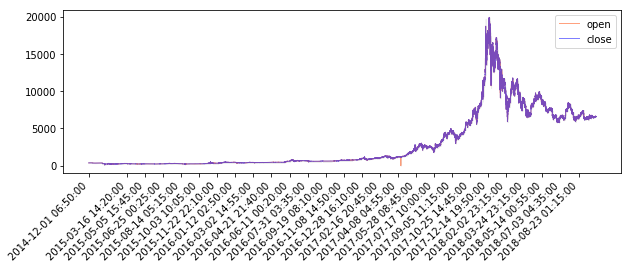

In [25]:
data = pd.read_csv(INPUT_FILENAME, index_col='timestamp')
# data = data.reindex(index=data.index[::-1])
data.sort_index(inplace=True)
orig_data_size = len(data)
print('size:', orig_data_size)
dd(data.head())
dd(data.tail())
simple_plot(data, xticks_span=30 * 24 * 60 // 3)

In [8]:
def add_empty(df, dt, inplace=False):
    if not inplace:
        df = df.copy()
    empty_row = [np.nan] * df.columns.size
    ts = df.iloc[-1].name - dt
    ts_end = df.iloc[0].name
    while ts > ts_end:
        if ts not in df.index:     
            empty_row[0] = helpers.ts_to_dt_str(ts)
            df.loc[ts] = empty_row
        ts -= dt
    df.sort_index(inplace=True)
    return df

In [9]:
data = add_empty(data, 300, inplace=True)

In [10]:
print('data size went from %d to %d' % (orig_data_size, len(data)))
print('missing points that needed to be added:',
    len(data) - orig_data_size)

data size went from 388209 to 405710
missing points that needed to be added: 17501


In [11]:
# plot empty points percent
def plot_empties(data):
    ncs = np.zeros((len(data) - 100) // 100 + 1)
    for i in range(0, len(data) - 100, 100):
        ncs[i // 100] = data.iloc[i: i + 100]['close'].isna().sum()
    plt.bar(np.arange(len(ncs)), ncs)

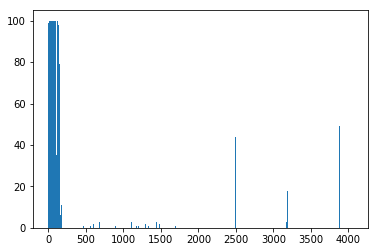

In [12]:
plot_empties(data)

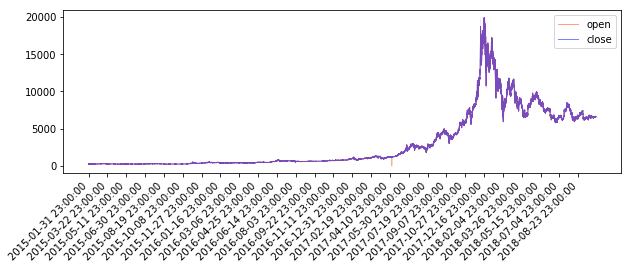

In [13]:
# pick a cut-off data to throw away older data because it's bad
ts_from = int(helpers.ymd_to_ts(2015, 2, 1))
# get first index after cut-off point (maybe the very same)
ts_from = data.loc[data.index >= ts_from].iloc[0].name
data = data.loc[ts_from:]
simple_plot(data, xticks_span=30 * 24 * 60 // 3)

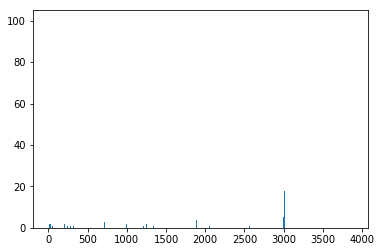

In [14]:
plot_empties(data)

In [17]:
data.fillna(method='ffill', inplace=True)

/home/neuronq/miniconda3/envs/ucap/lib/python2.7/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


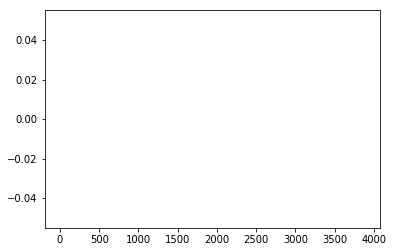

In [18]:
plot_empties(data)

In [33]:
data.datetime.duplicated().sum()

0

In [36]:
data.to_csv(OUT_FILENAME)